In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle  
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#Loading the mc data
mc_data = np.load("data_in/jpsi_mc_dump_data.npy", allow_pickle=True)
comb_data = np.load("data_in/comb_mc_dump_data.npy", allow_pickle=True)

In [3]:
def extract_features(data, max_events=600000, normalize=True, scale_range=(0, 1)):
    if data.shape[0] > max_events:
        indices = np.random.choice(data.shape[0], size=max_events, replace=False)
        data = data[indices]  # Select exactly max_events randomly
    
    px_mup = data[:, 0]
    py_mup = data[:, 1]
    pz_mup = data[:, 2]
    px_mum = data[:, 3]
    py_mum = data[:, 4]
    pz_mum = data[:, 5]
    mass_dimu = data[:, 6]
    pt_dimu = data[:, 7]
    phi_dimu = data[:, 8]
    
    features = np.vstack((px_mup, py_mup, pz_mup, px_mum, py_mum, pz_mum, mass_dimu, pt_dimu, phi_dimu)).T
    
    if normalize:
        # Apply min-max scaling to the features
        min_val = features.min(axis=0)
        max_val = features.max(axis=0)
        range_val = max_val - min_val
        features = (features - min_val) / range_val  # Normalize to (0, 1)

        # Check if there are any NaN values in the features array
        if np.isnan(features).any():
            print("There are NaN values in the features!")
        else:
            print("No NaN values in the features.")
            
        if scale_range != (0, 1):
            feature_range = scale_range[1] - scale_range[0]
            features = features * feature_range + scale_range[0]
    return features
    


# Extract 600k events from both MC and Combinatorial datasets
mc_features = extract_features(mc_data, max_events=600000)
comb_features = extract_features(comb_data, max_events=600000)

# Labels: Signal (1) for J/Psi, Background (0) for Combinatorial
mc_labels = np.ones((mc_features.shape[0], 1))    
comb_labels = np.zeros((comb_features.shape[0], 1))  

print("MC dataset size:", mc_features.shape[0])
print("Combinatorial background dataset size:", comb_features.shape[0])


X = np.vstack((mc_features, comb_features))   
y = np.vstack((mc_labels, comb_labels))       

X, y = shuffle(X, y, random_state=42)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, y_tensor)

#splitting the data
train_size = int(0.7 * len(dataset))   
val_size = int(0.15 * len(dataset))    
test_size = len(dataset) - train_size - val_size   
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   

# Check the first batch from the test DataLoader
for batch_idx, (data, target) in enumerate(test_loader):
    print(f"Test Batch {batch_idx + 1}:")
    print(f"Data shape: {data.shape}")
    print(f"Target shape: {target.shape}")
    break   


No NaN values in the features.
No NaN values in the features.
MC dataset size: 600000
Combinatorial background dataset size: 600000
Test Batch 1:
Data shape: torch.Size([64, 9])
Target shape: torch.Size([64, 1])


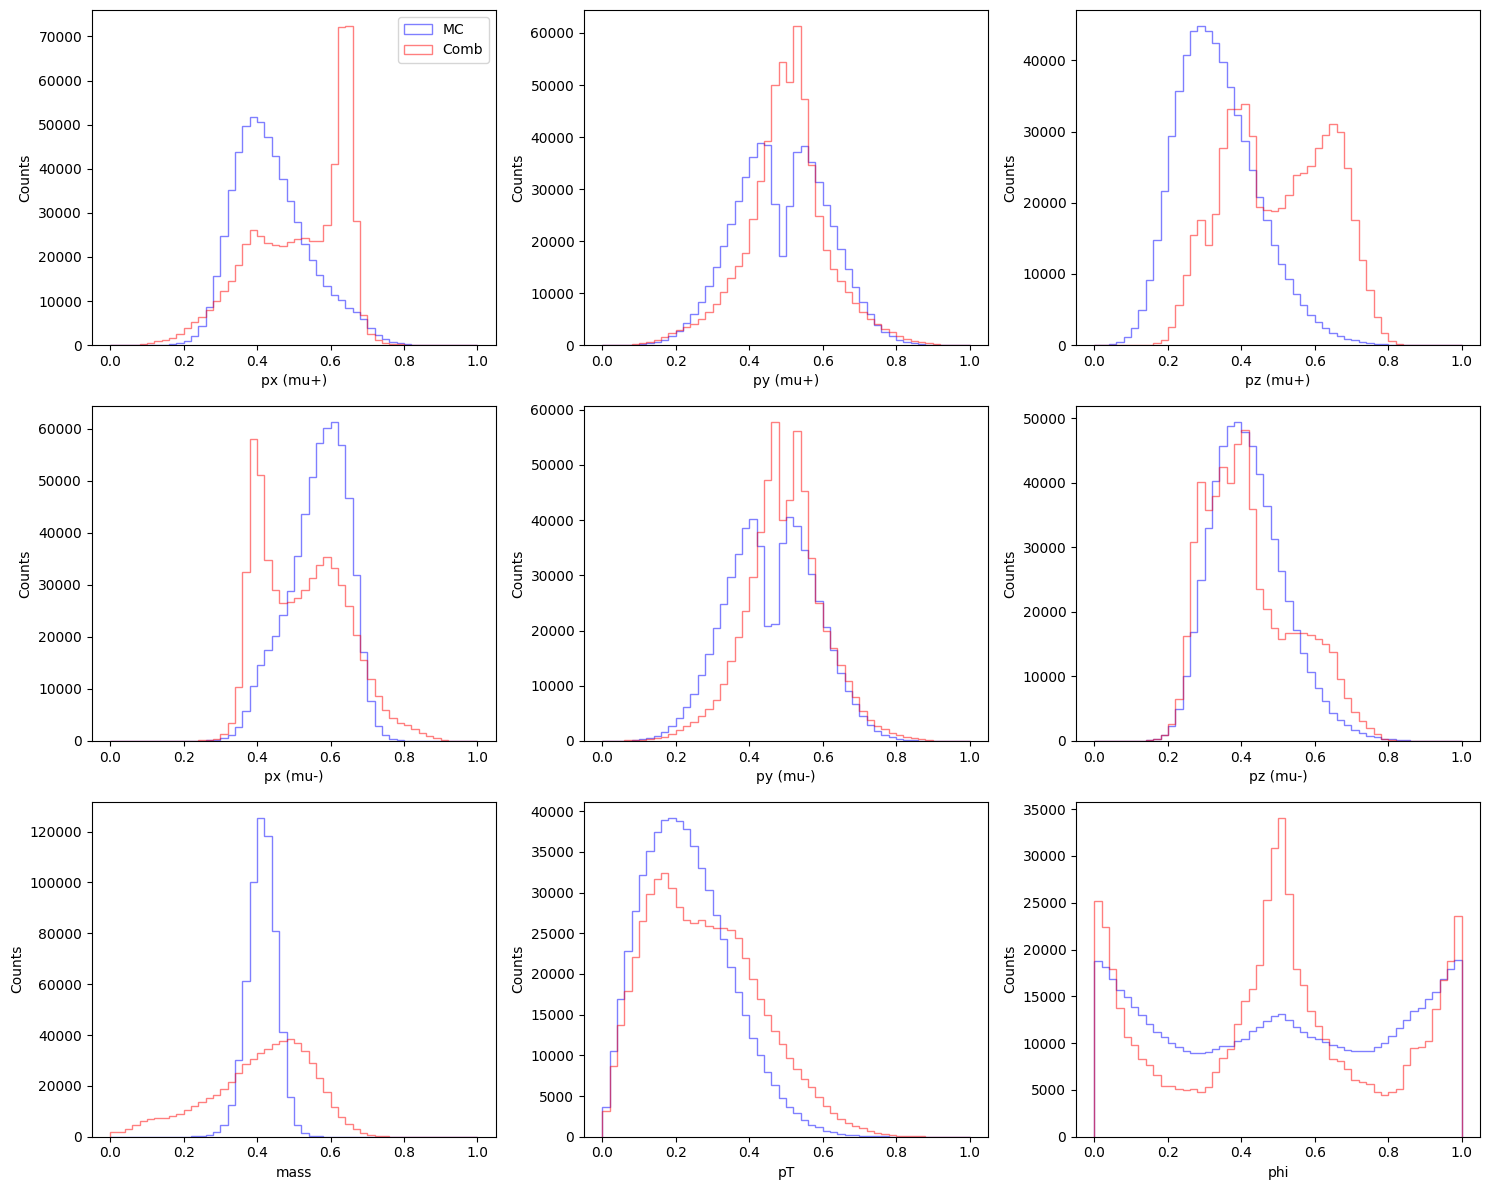

In [4]:
#the feature values are normalized ones
plt.figure(figsize=(15, 12))
bins = 50   
feature_names = ["px (mu+)", "py (mu+)", "pz (mu+)", 
                 "px (mu-)", "py (mu-)", "pz (mu-)", 
                 "mass", "pT", "phi"]

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.hist(mc_features[:, i], bins=bins, histtype="step", alpha=0.5, label="MC", density=False, color='b')
    plt.hist(comb_features[:, i], bins=bins, histtype="step", alpha=0.5, label="Comb", density=False, color='r')
    plt.xlabel(feature_names[i])
    plt.ylabel("Counts")
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()


In [5]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)   
        self.relu1 = nn.ReLU()                          
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)   
        self.relu2 = nn.ReLU()                          
        self.fc3 = nn.Linear(hidden_size2, output_size)   
        self.sigmoid = nn.Sigmoid()                     
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

input_size = 9       
hidden_size1 = 64    
hidden_size2 = 32    
output_size = 1  
learning_rate = 0.0001
num_epochs = 100


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeedForwardNN(input_size=input_size, hidden_size1=hidden_size1, hidden_size2=hidden_size2, output_size=output_size).to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Training phase
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)          
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        predicted = (outputs > 0.5).float()  # Convert sigmoid output to 0 or 1
        correct_predictions += (predicted == target).sum().item()
        total_predictions += target.size(0)
        running_loss += loss.item()
        # if batch_idx == 0:  # Only for the first batch
        #     print("Input data (first few events):")
        #     print(data[:5])   
        #     print(f"Data shape: {data.shape}")   
        #     print(f"Target shape: {target.shape}") 
        #     print(f"outputs: {outputs}")
        #     print(f"data: {data}")
        #     print(f"loss: {loss}")
        #     print(f"predicted: {predicted}")
        #     print(f"target: {target}")

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions * 100
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()  
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            # Calculate validation accuracy
            predicted = (outputs > 0.5).float()  # Convert sigmoid output to 0 or 1
            val_correct_predictions += (predicted == target).sum().item()
            val_total_predictions += target.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct_predictions / val_total_predictions * 100
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch [1/100] - Train Loss: 0.3852, Train Accuracy: 82.59% - Validation Loss: 0.2807, Validation Accuracy: 88.56%
Epoch [2/100] - Train Loss: 0.2120, Train Accuracy: 91.87% - Validation Loss: 0.1668, Validation Accuracy: 93.78%
Epoch [3/100] - Train Loss: 0.1485, Train Accuracy: 94.55% - Validation Loss: 0.1360, Validation Accuracy: 95.05%
Epoch [4/100] - Train Loss: 0.1229, Train Accuracy: 95.56% - Validation Loss: 0.1130, Validation Accuracy: 95.96%
Epoch [5/100] - Train Loss: 0.1060, Train Accuracy: 96.25% - Validation Loss: 0.1007, Validation Accuracy: 96.45%
Epoch [6/100] - Train Loss: 0.0967, Train Accuracy: 96.62% - Validation Loss: 0.0940, Validation Accuracy: 96.72%
Epoch [7/100] - Train Loss: 0.0911, Train Accuracy: 96.82% - Validation Loss: 0.0895, Validation Accuracy: 96.89%
Epoch [8/100] - Train Loss: 0.0864, Train Accuracy: 97.01% - Validation Loss: 0.0843, Validation Accuracy: 97.09%
Epoch [9/100] - Train Loss: 0.0823, Train Accuracy: 97.17% - Validation Loss: 0.0818, Va

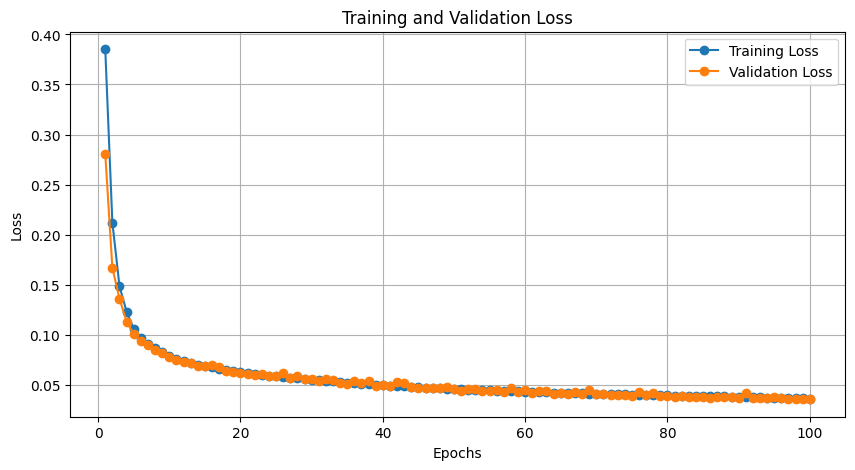

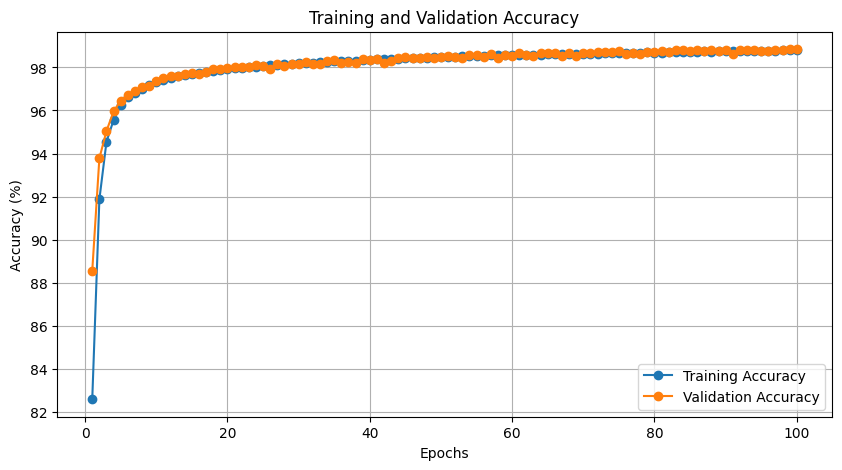

In [7]:
epochs = range(1, num_epochs + 1)
# Losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracies
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
all_probs, all_preds, all_labels, all_mass_dimu = [], [], [], []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)

        all_mass_dimu.append(features[:, 6].cpu().numpy())

        probabilities = model(features).squeeze()
        predicted_labels = (probabilities >= 0.5).int()

        all_probs.append(probabilities.cpu().numpy())
        all_preds.append(predicted_labels.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_probs = np.concatenate(all_probs)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels).astype(int).flatten()  # Ensure all_labels is 1D
all_mass_dimu = np.concatenate(all_mass_dimu).flatten()

print("Mass, Prob, Pred Class, True Class")
for mass, prob, pred, true in zip(all_mass_dimu[:20], all_probs[:20], all_preds[:20], all_labels[:20]):  
    print(f"{mass:.4f}, {prob:.4f}, {pred}, {true}")


Mass, Prob, Pred Class, True Class
0.4784, 0.0000, 0, 0
0.6399, 0.0000, 0, 0
0.3993, 1.0000, 1, 1
0.4462, 0.0282, 0, 0
0.4487, 0.0150, 0, 0
0.4150, 1.0000, 1, 1
0.3218, 0.0309, 0, 0
0.3870, 0.0069, 0, 0
0.4144, 0.0002, 0, 0
0.4570, 0.0043, 0, 0
0.5104, 0.0071, 0, 0
0.4212, 1.0000, 1, 1
0.2578, 0.0001, 0, 0
0.3994, 1.0000, 1, 1
0.3874, 0.9919, 1, 1
0.2548, 0.0000, 0, 0
0.4736, 0.0003, 0, 0
0.4237, 1.0000, 1, 1
0.3614, 1.0000, 1, 1
0.3594, 0.0013, 0, 0


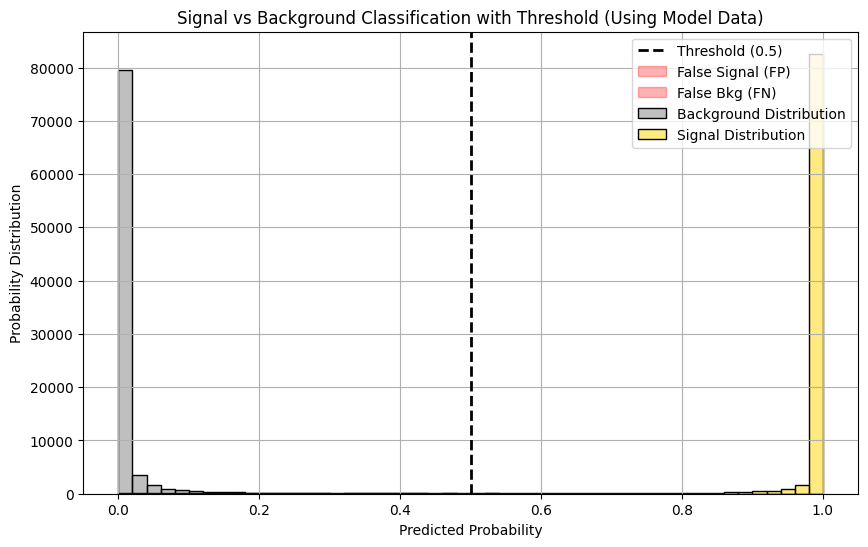

In [9]:
# Extract signal and background probabilities based on true labels
signal_probs = all_probs[all_labels == 1]  # Probabilities for signal events
background_probs = all_probs[all_labels == 0]  # Probabilities for background events
threshold = 0.5
# Compute TP, TN, FP, FN based on threshold
TN = background_probs[background_probs < threshold]   
FP = background_probs[background_probs >= threshold]   
FN = signal_probs[signal_probs < threshold]   
TP = signal_probs[signal_probs >= threshold]   

plt.figure(figsize=(10, 6))
sns.histplot(background_probs, bins=50, color='gray', kde=False, label='Background Distribution', alpha=0.5)
sns.histplot(signal_probs, bins=50, color='gold', kde=False, label='Signal Distribution', alpha=0.5)
plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
plt.fill_betweenx(y=[0, 5], x1=threshold, x2=1, color='red', alpha=0.3, label="False Signal (FP)")
plt.fill_betweenx(y=[0, 5], x1=0, x2=threshold, color='red', alpha=0.3, label="False Bkg (FN)")
plt.xlabel("Predicted Probability")
plt.ylabel("Probability Distribution")
plt.title("Signal vs Background Classification with Threshold (Using Model Data)")
plt.legend()
plt.grid(True)
plt.show()


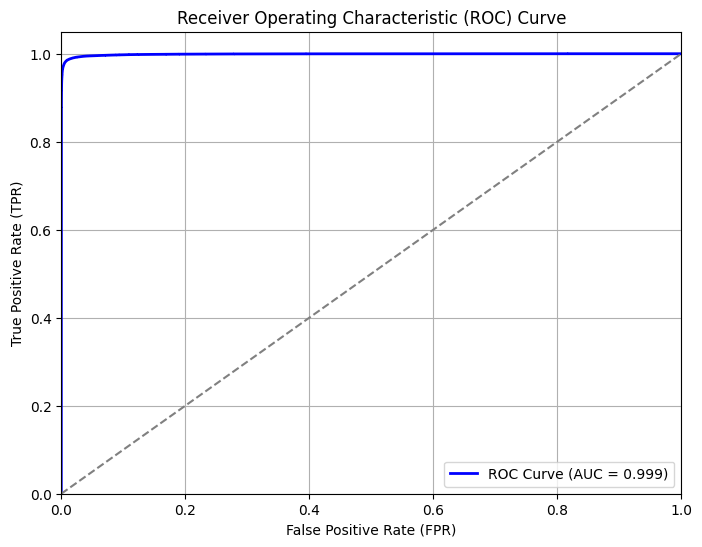

In [10]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


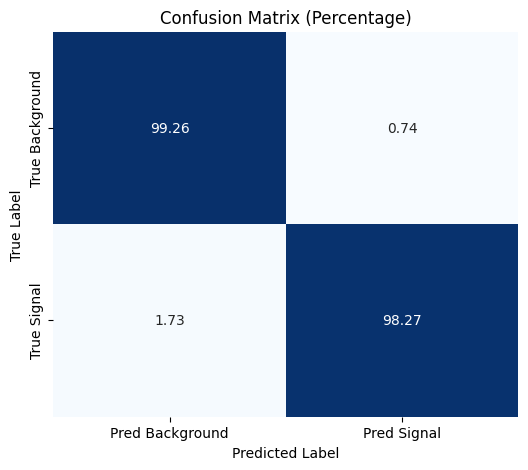

In [11]:
#confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_percentage = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100  
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_percentage, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=["Pred Background", "Pred Signal"], 
    yticklabels=["True Background", "True Signal"],
    cbar=False  
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

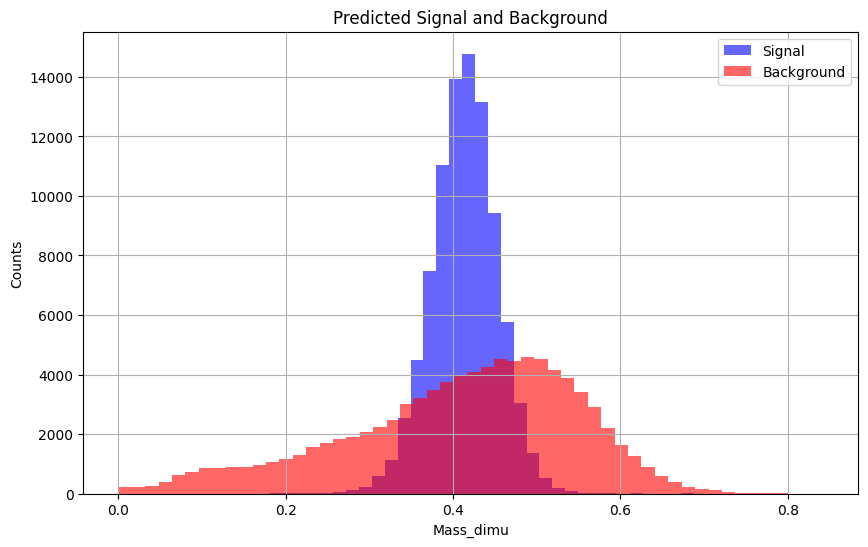

In [12]:
signal_mass_dimu = all_mass_dimu[all_labels == 1]  # Signal (label = 1)
background_mass_dimu = all_mass_dimu[all_labels == 0]  # Background (label = 0)
plt.figure(figsize=(10, 6))
plt.hist(signal_mass_dimu, bins=50, color='blue', alpha=0.6, label='Signal')
plt.hist(background_mass_dimu, bins=50, color='red', alpha=0.6, label='Background')
plt.xlabel('Mass_dimu')
plt.ylabel('Counts')
plt.title('Predicted Signal and Background')
plt.legend()
plt.grid(True)
plt.show()
